In [1]:
#from langchain_experimental.agents import create_pandas_dataframe_agent
import os
import json

import pandas as pd 
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import CausalInference
from dataLoader import DataLoader
from plotter import Plotter
from hyperParameterTuning import HyperparameterTuner
from counterfactualAnalyzer import CounterfactualAnalyzer


c:\Users\praskulkarni\.conda\envs\mtech-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


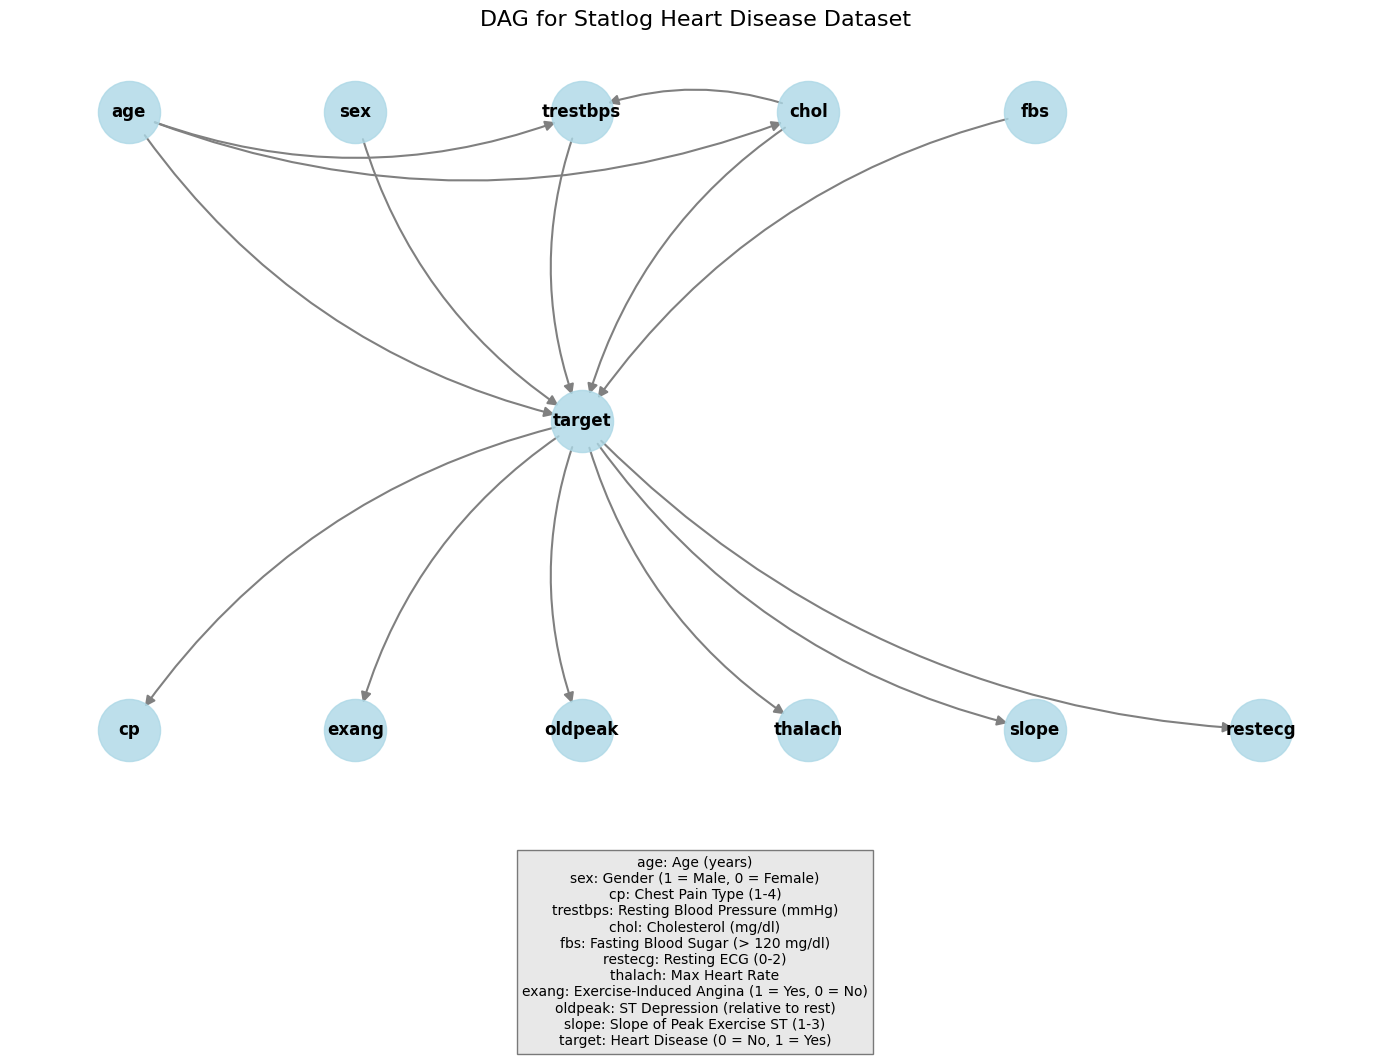

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the graph
G = nx.DiGraph()

# Define the variables from the dataset description
nodes = {
    "age": "Age (years)",
    "sex": "Gender (1 = Male, 0 = Female)",
    "cp": "Chest Pain Type (1-4)",
    "trestbps": "Resting Blood Pressure (mmHg)",
    "chol": "Cholesterol (mg/dl)",
    "fbs": "Fasting Blood Sugar (> 120 mg/dl)",
    "restecg": "Resting ECG (0-2)",
    "thalach": "Max Heart Rate",
    "exang": "Exercise-Induced Angina (1 = Yes, 0 = No)",
    "oldpeak": "ST Depression (relative to rest)",
    "slope": "Slope of Peak Exercise ST (1-3)",
    "target": "Heart Disease (0 = No, 1 = Yes)",
}

# Add nodes to the graph
G.add_nodes_from(nodes.keys())

# Define edges based on causal relationships
edges = [
    # Risk factors directly influencing heart disease
    ("age", "target"),
    ("sex", "target"),
    ("trestbps", "target"),
    ("chol", "target"),
    ("fbs", "target"),

    # Symptoms influenced by heart disease
    ("target", "cp"),
    ("target", "exang"),
    ("target", "oldpeak"),
    ("target", "thalach"),
    ("target", "slope"),
    ("target", "restecg"),

    # Interactions among risk factors
    ("age", "trestbps"),  # Age affects blood pressure
    ("age", "chol"),      # Age affects cholesterol
    ("chol", "trestbps"), # Cholesterol affects blood pressure
]

# Add edges to the graph
G.add_edges_from(edges)

# Adjusted node positions with more spacing
pos = {
    "age": (0, 4),
    "sex": (2, 4),
    "trestbps": (4, 4),
    "chol": (6, 4),
    "fbs": (8, 4),
    "target": (4, 2),  # Heart disease in the center
    "cp": (0, 0),
    "exang": (2, 0),
    "oldpeak": (4, 0),
    "thalach": (6, 0),
    "slope": (8, 0),
    "restecg": (10, 0),
}

# Draw the graph with larger figure size
plt.figure(figsize=(14, 10))

# Draw nodes with smaller size
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue", alpha=0.8)

# Draw edges with improved parameters
# - curved arrows with higher arc
# - adjusted arrow style to appear outside nodes
nx.draw_networkx_edges(
    G, 
    pos, 
    arrowsize=15, 
    connectionstyle="arc3,rad=0.2",  # Increase curve radius
    width=1.5, 
    edge_color="gray",
    arrows=True,
    arrowstyle='-|>',  # Arrow style that extends from the node
    min_source_margin=20,  # Start margin from node
    min_target_margin=20   # End margin to node
)

# Draw labels with just the variable names
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

# Add a title
plt.title("DAG for Statlog Heart Disease Dataset", fontsize=16)

# Add descriptions as a legend
plt.figtext(0.5, -0.05, "\n".join([f"{k}: {v}" for k, v in nodes.items()]), 
           horizontalalignment='center', fontsize=10, 
           bbox=dict(facecolor='lightgrey', alpha=0.5))

plt.axis("off")  # Turn off axis
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Make room for the legend
plt.show()

In [3]:
# Load dataset using DataLoader
dataLoader = DataLoader("heart_statlog_cleveland_hungary_final.csv")
df_cvd = dataLoader.load_data()
if df_cvd is not None:
   df_cvd = dataLoader.remove_outliers_iqr(df_cvd)


Data loaded successfully.


In [4]:
df_cvd['target'] = df_cvd['target'].astype('category')
df_cvd['exang'] = df_cvd['exang'].astype('category')
df_cvd['fbs'] = df_cvd['fbs'].astype('category')
df_cvd['cp'] = df_cvd['cp'].astype('category')
df_cvd['restecg'] = df_cvd['restecg'].astype('category')
df_cvd['slope'] = df_cvd['slope'].astype('category')

In [7]:
from dowhy import gcm
causal_model = gcm.InvertibleStructuralCausalModel(G)

In [8]:
gcm.auto.assign_causal_mechanisms(causal_model, df_cvd)

In [9]:
gcm.fit(causal_model, df_cvd)


Fitting causal mechanism of node target: 100%|██████████| 12/12 [00:00<00:00, 24.13it/s] 


In [10]:
# Check model fit statistics
#print(gcm.evaluate_causal_model(causal_model, df_cvd))

In [11]:

analyzer = CounterfactualAnalyzer(causal_model)
analyzer.process_all_instances()



Processing instances:   2%|▏         | 1/48 [00:00<00:07,  6.65it/s]


Processing instance 0

Processing instance 1


Processing instances:   6%|▋         | 3/48 [00:00<00:06,  7.44it/s]


Processing instance 2

Processing instance 3


Processing instances:  10%|█         | 5/48 [00:00<00:06,  6.60it/s]


Processing instance 4

Processing instance 5


Processing instances:  15%|█▍        | 7/48 [00:01<00:06,  6.45it/s]


Processing instance 6

Processing instance 7


Processing instances:  19%|█▉        | 9/48 [00:01<00:06,  6.26it/s]


Processing instance 8

Processing instance 9


Processing instances:  23%|██▎       | 11/48 [00:01<00:05,  6.40it/s]


Processing instance 10

Processing instance 11


Processing instances:  27%|██▋       | 13/48 [00:01<00:05,  6.50it/s]


Processing instance 12

Processing instance 13


Processing instances:  31%|███▏      | 15/48 [00:02<00:05,  6.49it/s]


Processing instance 14

Processing instance 15


Processing instances:  35%|███▌      | 17/48 [00:02<00:04,  6.75it/s]


Processing instance 16

Processing instance 17


Processing instances:  40%|███▉      | 19/48 [00:02<00:04,  6.87it/s]


Processing instance 18

Processing instance 19


Processing instances:  44%|████▍     | 21/48 [00:03<00:04,  6.43it/s]


Processing instance 20

Processing instance 21


Processing instances:  48%|████▊     | 23/48 [00:03<00:03,  6.36it/s]


Processing instance 22

Processing instance 23


Processing instances:  52%|█████▏    | 25/48 [00:03<00:03,  6.12it/s]


Processing instance 24

Processing instance 25


Processing instances:  56%|█████▋    | 27/48 [00:04<00:03,  5.72it/s]


Processing instance 26

Processing instance 27


Processing instances:  60%|██████    | 29/48 [00:04<00:03,  6.08it/s]


Processing instance 28

Processing instance 29


Processing instances:  65%|██████▍   | 31/48 [00:04<00:02,  6.30it/s]


Processing instance 30

Processing instance 31


Processing instances:  69%|██████▉   | 33/48 [00:05<00:02,  5.52it/s]


Processing instance 32

Processing instance 33


Processing instances:  73%|███████▎  | 35/48 [00:05<00:02,  6.17it/s]


Processing instance 34

Processing instance 35


Processing instances:  77%|███████▋  | 37/48 [00:05<00:01,  5.93it/s]


Processing instance 36

Processing instance 37


Processing instances:  81%|████████▏ | 39/48 [00:06<00:01,  6.04it/s]


Processing instance 38

Processing instance 39


Processing instances:  85%|████████▌ | 41/48 [00:06<00:01,  6.45it/s]


Processing instance 40

Processing instance 41


Processing instances:  88%|████████▊ | 42/48 [00:06<00:01,  5.74it/s]


Processing instance 42


Processing instances:  90%|████████▉ | 43/48 [00:07<00:01,  4.62it/s]


Processing instance 43


Processing instances:  94%|█████████▍| 45/48 [00:07<00:00,  4.49it/s]


Processing instance 44

Processing instance 45


Processing instances:  98%|█████████▊| 47/48 [00:07<00:00,  4.75it/s]


Processing instance 46

Processing instance 47


Processing instances: 100%|██████████| 48/48 [00:08<00:00,  5.91it/s]



COUNTERFACTUAL ANALYSIS SUMMARY
Total instances processed: 48
Instances with counterfactuals: 48
Failed instances: 0
Total counterfactuals generated: 237
Working counterfactuals (target=0): 94
Processing time: 8.13 seconds

Distance metrics for all counterfactuals:
       euclidean_distance  manhattan_distance
count          237.000000          237.000000
mean            34.209973           47.338894
std             17.954465           23.274236
min              4.472136           10.000000
25%             20.688161           29.765175
50%             31.407642           43.000000
75%             44.045431           64.000000
max            101.705457          126.000000

Distance metrics for working counterfactuals:
       euclidean_distance  manhattan_distance
count           94.000000           94.000000
mean            34.891912           48.925855
std             19.819447           24.830090
min              4.472136           10.000000
25%             17.665906           28.825

Causal Bayesian Network

In [ ]:
dataLoader = DataLoader("heart_statlog_cleveland_hungary_final.csv")
df_train = dataLoader.load_data()
data_binner = DataBinner(df_train)
df_binned = data_binner.apply_binning()

In [ ]:

dataLoader_ = DataLoader("df_high_risk_tp.csv")
df_test = dataLoader_.load_data()
data_binner_ = DataBinner(df_test)
df_binned_ = data_binner_.apply_binning()

In [ ]:
'''from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import CausalInference

class BayesianNetworkModel:
    def __init__(self):
        self.model = None
        self.causal_inference = None

    def define_structure(self):
        self.model = BayesianNetwork([("age", "chol"),
                                      ("age", "trestbps"),
                                      ("sex", "chol"),
                                      ("sex", "trestbps"),
                                      ("sex", "target"),
                                      ("cp", "target"),
                                      ("trestbps", "target"),
                                      ("chol", "target"),
                                      ("fbs", "target"),
                                      ("restecg", "target"),
                                      ("thalach", "target"),
                                      ("thalach", "exang"),
                                      ("exang", "target"),
                                      ("oldpeak", "target"),
                                      ("oldpeak", "exang"),
                                      ("slope", "target"),
                                      ("slope", "exang")])

    def fit_model(self, data):
        if self.model is None:
            raise ValueError("Model structure is not defined. Call define_structure() first.")
        self.model.fit(data, estimator=MaximumLikelihoodEstimator)
        print("Model fitted successfully.")

    def initialize_causal_inference(self):
        if self.model is None:
            raise ValueError("Model is not defined. Call define_structure() and fit_model() first.")
        self.causal_inference = CausalInference(self.model)
        print("Causal inference initialized successfully.")

    def get_model(self):
        return self.model

    def get_causal_inference(self):
        return self.causal_inference'''


In [ ]:

# Assuming df_binned is your binned DataFrame
bayesian_network_model = BayesianNetworkModel()
bayesian_network_model.define_structure()
bayesian_network_model.fit_model(df_binned)
bayesian_network_model.initialize_causal_inference()

# Access the model and causal inference objects if needed
model = bayesian_network_model.get_model()
causal_inference = bayesian_network_model.get_causal_inference()

In [ ]:
intervene_model=model.do(['trestbps'])


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a NetworkX graph from the model's edges
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.shell_layout(G)
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color='lightcoral',
    font_size=10, font_weight='bold', arrowsize=20
)

# Display the graph
plt.title('Causal DAG for Cardiovascular Disease (CVD)')
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Create a NetworkX graph from the model's edges
G = nx.DiGraph()
G.add_edges_from(intervene_model.edges())

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.shell_layout(G)
nx.draw(
    G, pos, with_labels=True, node_size=3000, node_color='lightcoral',
    font_size=10, font_weight='bold', arrowsize=20
)

# Display the graph
plt.title('Causal DAG for Cardiovascular Disease (CVD)')
plt.show()

In [ ]:
# Check for NaN values in test_data
nan_rows = df_train[df_train.isna().any(axis=1)]
print(f"Rows with NaN values in test_data:\n{nan_rows}")

In [ ]:
# Check for NaN values in test_data
nan_rows = df_binned[df_binned.isna().any(axis=1)]
print(f"Rows with NaN values in test_data:\n{nan_rows}")

In [ ]:
df_binned[df_binned['target'] == 1].iloc[1]

In [ ]:
# Filter the DataFrame to find a row where target is 1
target_1_row = df_binned[df_binned['target'] == 1].iloc[1]

# Create an evidence dictionary from the selected row with discretized values
evidence = {
    'age': target_1_row['age'],
    'sex': target_1_row['sex'],
    'chol': target_1_row['chol'],
    'trestbps': target_1_row['trestbps'],
    'cp': target_1_row['cp'],
    'fbs': target_1_row['fbs'],
    'restecg': target_1_row['restecg'],
    'thalach': target_1_row['thalach'],
    'exang': target_1_row['exang'],
    'oldpeak': target_1_row['oldpeak'],
    'slope': target_1_row['slope']
}


In [ ]:
target_1_row

In [ ]:
evidence

In [ ]:
intervention = {'chol':0}

In [ ]:
# Calculate the target distribution before intervention
target_distribution_before = causal_inference.query(variables=['target'], evidence=evidence)

# Calculate the target distribution after intervention
target_distribution_after = causal_inference.query(variables=['target'], do=intervention, evidence=evidence)

# Print the target distributions
print("Target distribution before intervention:")
print(target_distribution_before)

print("Target distribution after intervention:")
print(target_distribution_after)

True Positive Examples

In [ ]:
'''# Apply binning functions to the respective columns
df_high_risk_tp['age_bin'] = df_high_risk_tp['age'].apply(bin_age)
df_high_risk_tp['chol_bin'] = df_high_risk_tp['chol'].apply(bin_chol)
df_high_risk_tp['trestbps_bin'] = df_high_risk_tp['trestbps'].apply(bin_trestbps)
df_high_risk_tp['thalach_bin'] = df_high_risk_tp['thalach'].apply(bin_thalach)
df_high_risk_tp['oldpeak_bin'] = df_high_risk_tp['oldpeak'].apply(bin_oldpeak)

# Create a new DataFrame with the binned column values
df_binned_tp = df_high_risk_tp.copy(deep=True)
df_binned_tp['age'] = df_binned_tp['age_bin']
df_binned_tp['chol'] = df_binned_tp['chol_bin']
df_binned_tp['trestbps'] = df_binned_tp['trestbps_bin']
df_binned_tp['thalach'] = df_binned_tp['thalach_bin']
df_binned_tp['oldpeak'] = df_binned_tp['oldpeak_bin']

# Drop the temporary binned columns
df_binned_tp.drop(columns=['age_bin', 'chol_bin', 'trestbps_bin', 'thalach_bin', 'oldpeak_bin'], inplace=True)

# Display the first few rows of the binned DataFrame
print(df_binned_tp.head())'''

In [ ]:
# Filter the DataFrame to find a row where target is 1
target_1_row = df_binned_[df_binned_['target'] == 1].iloc[3]

# Create an evidence dictionary from the selected row with discretized values
evidence = {
    'age': target_1_row['age'],
    'sex': target_1_row['sex'],
    'chol': target_1_row['chol'],
    'trestbps': target_1_row['trestbps'],
    'cp': target_1_row['cp'],
    'fbs': target_1_row['fbs'],
    'restecg': target_1_row['restecg'],
    'thalach': target_1_row['thalach'],
    'exang': target_1_row['exang'],
    'oldpeak': target_1_row['oldpeak'],
    'slope': target_1_row['slope']
}


In [ ]:
evidence

In [ ]:
# Calculate the target distribution before intervention
target_distribution_before = causal_inference.query(variables=['target'], evidence=evidence)


# Print the target distributions
print("Target distribution before intervention:")
print(target_distribution_before)



In [ ]:
# Get the CPDs for each variable in the evidence dictionary
cpds_evidence = {var: model.get_cpds(var) for var in evidence.keys()}

# Print the CPDs for each evidence variable
for var, cpd in cpds_evidence.items():
    print(f"CPD of {var}:")
    print(cpd)
    print("\n")


In [ ]:
intervention = {'chol': 0,'trestbps':2}

In [ ]:

# Calculate the target distribution after intervention
target_distribution_after = causal_inference.query(variables=['target'], do=intervention, evidence=evidence)

print("Target distribution after intervention:")
print(target_distribution_after)

In [ ]:
from copy import deepcopy
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
import networkx as nx
# Step 2: Perform the Intervention
intervened_model = deepcopy(model)

# Remove edges into 'chol' to reflect the intervention
intervened_model.remove_edge('age', 'chol')
intervened_model.remove_edge('sex', 'chol')

# Modify the CPD of 'chol'
original_cpd_chol = model.get_cpds('chol')
state_names_chol = original_cpd_chol.state_names['chol']
variable_card_chol = original_cpd_chol.variable_card
intervened_state = state_names_chol[0]  # Set 'chol' to the first state

intervened_values = [[1.0 if state == intervened_state else 0.0] for state in state_names_chol]

intervened_cpd_chol = TabularCPD(
    variable='chol',
    variable_card=variable_card_chol,
    values=intervened_values,
    state_names={'chol': state_names_chol}
)

intervened_model.remove_cpds('chol')
intervened_model.add_cpds(intervened_cpd_chol)
assert intervened_model.check_model()

# Step 3: Re-Learn the CPDs of Descendants
descendants = nx.descendants(intervened_model, 'chol')

# Generate data from the intervened model
sampler = BayesianModelSampling(intervened_model)
intervened_data = sampler.forward_sample(size=10000, seed=42)

# Re-fit the CPDs of the descendants
intervened_model.fit(
    intervened_data,
    estimator=MaximumLikelihoodEstimator,
 
)
assert intervened_model.check_model()

# Step 4: Access and Display the Updated CPDs
for node in descendants:
    cpd = intervened_model.get_cpds(node)
    print(f"CPD of {node} after intervention:")
    print(cpd)
    print()

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD


def do(model: BayesianNetwork, interventions: dict):
    """ 
    Implement an ideal intervention for discrete variables. Modifies pgmpy's
    `do` method so it is a `do`-operator, meaning a function that takes in a
    model, modifies it with an ideal intervention, and returns a new model.
    Note that this code would need to be modified to work for continuous
    variables.
    """
    def _mod_kernel(kernel: TabularCPD, int_val):
        """
        Modify a causal Markov kernel so all probability is on the state fixed
        by the intervention.
        """ 
        var_name = kernel.variable
        card = kernel.get_cardinality([var_name])[var_name]
        states = [kernel.get_state_names(var_name, i) for i in range(card)]
        non_int_states = set(states) - {int_val,}
        unordered_prob_vals = [[1.0]] + [[0.0] for _ in range(card - 1)]
        unordered_states = [int_val] + list(non_int_states)
        # Reorder so it matches original
        dict_ = dict(zip(unordered_states, unordered_prob_vals))
        ordered_prob_values = [dict_[k] for k in states]
        intervention_kernel = TabularCPD(
            var_name, card, ordered_prob_values,
            state_names = {var_name: states}
        )
        return intervention_kernel

    kernels = {kern.variable: kern for kern in model.get_cpds()}
    new_model = model.copy()
    for var, int_val in interventions.items():
        new_model = new_model.do(var)
        new_kernel = _mod_kernel(kernels[var], int_val)
        new_model.add_cpds(new_kernel)
    return new_model
    

In [ ]:
intervention = {'chol': 0,'trestbps':2}
new_model = do(model, intervention)


In [ ]:
for cpd in new_model.get_cpds():
    print(f"CPD of {cpd.variable} after intervention:")
    print(cpd)

In [ ]:

# Directly access the CPDs for the evidence variables from the model
cpds_evidence_after_intervention = {var: intervene_model.get_cpds(var) for var in evidence.keys()}

# Print the CPDs for each evidence variable after intervention
for var, cpd in cpds_evidence_after_intervention.items():
    print(f"\nCPD of {var} after intervention:")
    print(cpd)

In [ ]:
# Calculate the target distribution before intervention
target_distribution_before = causal_inference.query(variables=['target'], evidence=evidence)

# Calculate the target distribution after intervention
target_distribution_after = causal_inference.query(variables=['target'], do=intervention, evidence=evidence)

# Print the target distributions
print("Target distribution before intervention:")
print(target_distribution_before)

print("Target distribution after intervention:")
print(target_distribution_after)

In [ ]:
from pgmpy.inference import VariableElimination
# Perform inference
inference = VariableElimination(model)
target_prediction = inference.query(variables=['target'], evidence=evidence)

# Print the predicted target
print("Predicted target:", target_prediction)

In [ ]:
cpds = model.get_cpds()
for cpd in cpds:
    print(cpd)

In [ ]:
# Predict the probability distribution of the target given the intervention
target_distribution = causal_inference.query(variables=['target'], do=intervention, evidence=evidence)

# Print the probability distribution of the target
print("Probability distribution of the target given the intervention:")
print(target_distribution)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ExpectationMaximization
from pgmpy.inference import VariableElimination

# Assuming df_binned is already defined and preprocessed
# Train-Test Split
train_data, test_data = train_test_split(df_binned, test_size=0.2, random_state=42)

# Define the Bayesian Network structure
dag = [('age', 'chol'),
       ('age', 'trestbps'),
       ('sex', 'chol'),
       ('sex', 'trestbps'),
       ('sex', 'target'),
       ('cp', 'target'),
       ('trestbps', 'target'),
       ('chol', 'target'),
       ('fbs', 'target'),
       ('restecg', 'target'),
       ('thalach', 'target'),
       ('thalach', 'exang'),
       ('exang', 'target'),
       ('oldpeak', 'target'),
       ('oldpeak', 'exang'),
       ('slope', 'target'),
       ('slope', 'exang')]

# Create the Bayesian Network
model = BayesianNetwork(dag)

# Fit the model using Bayesian Estimator with Laplace smoothing
model.fit(train_data, estimator=ExpectationMaximization)

# Function to evaluate the model
def evaluate_model(model, test_data):
    inference = VariableElimination(model)
    predictions = []
    for index, row in test_data.iterrows():
        evidence = row.drop('target').to_dict()
        try:
            target_distribution = inference.map_query(variables=['target'], evidence=evidence)
            predictions.append(target_distribution['target'])
        except Exception:
            predictions.append(None)
    
    actual = test_data['target'].values
    filtered_predictions = [p for p in predictions if p is not None]
    filtered_actual = [a for p, a in zip(predictions, actual) if p is not None]
    
    accuracy = accuracy_score(filtered_actual, filtered_predictions)
    precision = precision_score(filtered_actual, filtered_predictions, average='weighted')
    recall = recall_score(filtered_actual, filtered_predictions, average='weighted')
    f1 = f1_score(filtered_actual, filtered_predictions, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(model, test_data)

# Print the results
print("Bayesian Estimator with Laplace Smoothing:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, K2Score, HillClimbSearch
from pgmpy.inference import VariableElimination
import numpy as np

# Train-Test Split
train_data, test_data = train_test_split(df_binned, test_size=0.2, random_state=42)

# Structure Learning
hc = HillClimbSearch(train_data)
best_model = hc.estimate(scoring_method=K2Score(train_data))

# Fit the model using the training data with Laplace smoothing
model = BayesianNetwork(best_model.edges())
model.fit(train_data, estimator=MaximumLikelihoodEstimator, state_names=train_data.columns)

# Evaluate the model using the testing data
inference = VariableElimination(model)

# Predict the target variable for the test set
predictions = []
for index, row in test_data.iterrows():
    evidence = {
        'age': row['age'],
        'sex': row['sex'],
        'chol': row['chol'],
        'trestbps': row['trestbps'],
        'cp': row['cp'],
        'fbs': row['fbs'],
        'restecg': row['restecg'],
        'thalach': row['thalach'],
        'exang': row['exang'],
        'oldpeak': row['oldpeak'],
        'slope': row['slope']
    }

    # Check for NaN values and skip the row if any are found
    if any(pd.isna(v) for v in evidence.values()):
        print(f"Skipping row {index} due to NaN values in evidence")
        continue

    # Ensure all evidence values are integers
    evidence = {k: int(v) for k, v in evidence.items()}

    try:
        target_distribution = inference.map_query(variables=['target'], evidence=evidence)
        predictions.append(target_distribution['target'])
    except IndexError as e:
        print(f"IndexError for row {index}: {e}")
        predictions.append(None)

# Actual target values
actual = test_data['target'].values

# Filter out None predictions and corresponding actual values
filtered_predictions = []
filtered_actual = []
for i in range(len(predictions)):
    if predictions[i] is not None:
        filtered_predictions.append(predictions[i])
        filtered_actual.append(actual[i])

# Calculate accuracy metrics
accuracy = accuracy_score(filtered_actual, filtered_predictions)
precision = precision_score(filtered_actual, filtered_predictions, average='weighted')
recall = recall_score(filtered_actual, filtered_predictions, average='weighted')
f1 = f1_score(filtered_actual, filtered_predictions, average='weighted')

# Print accuracy metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import numpy as np

# Train-Test Split
train_data, test_data = train_test_split(df_binned, test_size=0.2, random_state=42)

# Define the Bayesian Network structure
model = BayesianNetwork([('age', 'chol'),
                         ('age', 'trestbps'),
                         ('sex', 'chol'),
                         ('sex', 'trestbps'),
                         ('sex', 'target'),
                         ('cp', 'target'),
                         ('trestbps', 'target'),
                         ('chol', 'target'),
                         ('fbs', 'target'),
                         ('restecg', 'target'),
                         ('thalach', 'target'),
                         ('thalach', 'exang'),
                         ('exang', 'target'),
                         ('oldpeak', 'target'),
                         ('oldpeak', 'exang'),
                         ('slope', 'target'),
                         ('slope', 'exang')])

# Fit the model using the training data
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Evaluate the model using the testing data
inference = VariableElimination(model)

# Predict the target variable for the test set
predictions = []
for index, row in test_data.iterrows():
    evidence = {
        'age': row['age'],
        'sex': row['sex'],
        'chol': row['chol'],
        'trestbps': row['trestbps'],
        'cp': row['cp'],
        'fbs': row['fbs'],
        'restecg': row['restecg'],
        'thalach': row['thalach'],
        'exang': row['exang'],
        'oldpeak': row['oldpeak'],
        'slope': row['slope']
    }

    # Check for NaN values and skip the row if any are found
    if any(pd.isna(v) for v in evidence.values()):
        print(f"Skipping row {index} due to NaN values in evidence")
        continue

    # Ensure all evidence values are integers
    evidence = {k: int(v) for k, v in evidence.items()}

    try:
        target_distribution = inference.map_query(variables=['target'], evidence=evidence)
        predictions.append(target_distribution['target'])
    except IndexError as e:
        print(f"IndexError for row {index}: {e}")
        predictions.append(None)

# Actual target values
actual = test_data['target'].values

# Filter out None predictions and corresponding actual values
filtered_predictions = []
filtered_actual = []
for i in range(len(predictions)):
    if predictions[i] is not None:
        filtered_predictions.append(predictions[i])
        filtered_actual.append(actual[i])

# Calculate accuracy metrics
accuracy = accuracy_score(filtered_actual, filtered_predictions)
precision = precision_score(filtered_actual, filtered_predictions, average='weighted')
recall = recall_score(filtered_actual, filtered_predictions, average='weighted')
f1 = f1_score(filtered_actual, filtered_predictions, average='weighted')

# Print accuracy metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

PyAgrum

In [ ]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Define the Bayesian Network without ranges
model = gum.fastBN("age->chol;"
                   "age->trestbps;"
                   "sex->chol;"
                   "sex->trestbps;"
                   "sex->target;"
                   "cp->target;"
                   "trestbps->target;"
                   "chol->target;"
                   "fbs->target;"
                   "restecg->target;"
                   "thalach->target;"
                   "thalach->exang;"
                   "exang->target;"
                   "oldpeak->target;"
                   "oldpeak->exang;"
                   "slope->target;"
                   "slope->exang")


In [ ]:
# Learn the parameters from the data
learner = gum.BNLearner(df)
learner.useSparsityPrior()
learner.useAprioriSmoothing()
bn = learner.learnParameters(model)

# Display the Bayesian Network
gnb.showBN(bn)

SCM

bnlearn


In [ ]:
import bnlearn as bn

In [ ]:
df.head()

In [ ]:
# Display the DataFrame to check its contents
print(df.head())
print(df.shape)

In [ ]:
from pgmpy.models import BayesianNetwork

# Initial edges
edges = [
    ('age', 'chol'),
    ('age', 'trestbps'),
    ('sex', 'chol'),
    ('sex', 'trestbps'),
    ('sex', 'target'),
    ('cp', 'target'),
    ('trestbps', 'target'),
    ('chol', 'target'),
    ('fbs', 'target'),
    ('restecg', 'target'),
    ('thalach', 'target'),
    ('thalach', 'exang'),
    ('exang', 'target'),
    ('oldpeak', 'target'),
    ('oldpeak', 'exang'),
    ('slope', 'target'),
    ('slope', 'exang')
]

# Create the initial DAG
DAG = BayesianNetwork(edges)

# Function to check d-separation
def is_d_separated(DAG, X, Y, Z):
    return DAG.is_dconnected(X, Y, Z)

# Optimize the DAG by removing redundant edges
optimized_edges = edges.copy()
nodes = set([node for edge in edges for node in edge])  # Extract all unique nodes

for edge in edges:
    DAG_temp = BayesianNetwork()
    DAG_temp.add_nodes_from(nodes)  # Add all nodes to the temporary DAG
    DAG_temp.add_edges_from([e for e in optimized_edges if e != edge])  # Add edges except the current one
    if not is_d_separated(DAG_temp, edge[0], edge[1], []):
        optimized_edges.remove(edge)

# Print the optimized edges
print("Optimized edges:")
print(optimized_edges)

In [ ]:
from pgmpy.models import BayesianNetwork

# Initial edges
edges = [
    ('age', 'chol'),
    ('age', 'trestbps'),
    ('sex', 'chol'),
    ('sex', 'trestbps'),
    ('sex', 'target'),
    ('cp', 'target'),
    ('trestbps', 'target'),
    ('chol', 'target'),
    ('fbs', 'target'),
    ('restecg', 'target'),
    ('thalach', 'target'),
    ('thalach', 'exang'),
    ('exang', 'target'),
    ('oldpeak', 'target'),
    ('oldpeak', 'exang'),
    ('slope', 'target'),
    ('slope', 'exang')
]

# Variables that can be intervened upon
intervenable_vars = {'trestbps', 'fbs', 'chol'}

# Create the initial DAG
DAG = BayesianNetwork(edges)

# Function to check d-separation
def is_d_separated(DAG, X, Y, Z):
    return DAG.is_dconnected(X, Y, Z)

# Optimize the DAG by removing redundant edges
optimized_edges = edges.copy()
nodes = set([node for edge in edges for node in edge])  # Extract all unique nodes

for edge in edges:
    # Skip edges involving intervenable variables
    if edge[0] in intervenable_vars or edge[1] in intervenable_vars:
        continue
    
    DAG_temp = BayesianNetwork()
    DAG_temp.add_nodes_from(nodes)  # Add all nodes to the temporary DAG
    DAG_temp.add_edges_from([e for e in optimized_edges if e != edge])  # Add edges except the current one
    if not is_d_separated(DAG_temp, edge[0], edge[1], []):
        optimized_edges.remove(edge)

# Print the optimized edges
print("Optimized edges:")
print(optimized_edges)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Given edges
edges = [
    ('age', 'chol'),
    ('age', 'trestbps'),
    ('sex', 'chol'),
    ('sex', 'trestbps'),
    ('sex', 'target'),
    ('trestbps', 'target'),
    ('chol', 'target'),
    ('fbs', 'target'),
    ('thalach', 'target'),
    ('exang', 'target'),
    ('oldpeak', 'target'),
    ('slope', 'target')
]

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
plt.title('Bayesian Network DAG')
plt.show()